### Reward in all, easy, and hard sessions
- Comparing Unstruc and Struc where the difference in probability is more than 0.4 

In [ ]:
import numpy as np
import pandas as pd
import mab_subjects

exps = mab_subjects.unstruc.allsess + mab_subjects.struc.allsess
trial_filter = dict(min_trials=100, clip_max=100)

rwd_df = []

for i, exp in enumerate(exps):
    print(exp.sub_name)
    task = exp.b2a.filter_by_trials(**trial_filter)
    mab_easy = task.filter_by_deltaprob(delta_min=0.4)
    mab_hard = task.filter_by_deltaprob(delta_min=0, delta_max=0.35)

    rp = task.get_reward_probability()
    rp_easy = mab_easy.get_reward_probability()
    rp_hard = mab_hard.get_reward_probability()

    df = pd.DataFrame(
        dict(
            trial_id=np.arange(rp.size) + 1,
            rp=rp,
            rp_easy=rp_easy,
            rp_hard=rp_hard,
            name=exp.sub_name,
            grp="struc" if task.is_structured else "unstruc",
            first_experience=True if "Exp1" in exp.sub_name else False,
        )
    )
    rwd_df.append(df)

rwd_df = pd.concat(rwd_df, ignore_index=True)
mab_subjects.GroupData().save(rwd_df, "reward_prob_difficulty_level")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from neuropy import plotting
import mab_subjects
import numpy as np
from statplotannot.plots.colormaps import colors_mab
from statplotannot.plots import SeabornPlotter

fig = plotting.Fig(6, 3, num=1, fontsize=10)

grpdata = mab_subjects.GroupData()
df = grpdata.reward_prob_difficulty_level
df = df[df["first_experience"] == True]

ax = fig.subplot(fig.gs[0])
hue_order = ["unstruc", "struc"]
linestyles = ["-", "--", ":"]

for i, y in enumerate(["rp", "rp_easy", "rp_hard"]):

    plot_kw = dict(data=df, x="trial_id", y=y, hue="grp", hue_order=hue_order, ax=ax)
    sns.lineplot(
        palette=colors_mab(),
        # palette=["#E89317", "#176CE8"],
        # palette=["#d58915", "#1660d0"],
        lw=1.1,
        # edgecolor="white",
        # facecolor=(0, 0, 0, 0),
        # alpha=0.4,
        ls=linestyles[i],
        err_kws=dict(edgecolor="none"),
        errorbar="se",
        **plot_kw,
    )
SeabornPlotter.fix_legend(ax)

ax.set_title(r"Performance in all sessions")
ax.set_ylabel("Performance")
# ax.set_ylim(0.45, 1)
ax.set_xticks([1, 50, 100])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# ax.legend("")

### Reward rate matrix
- Bins are represented by probability combination

In [ ]:
import numpy as np
import pandas as pd
import mab_subjects
from scipy.ndimage import gaussian_filter1d

exps = mab_subjects.unstruc.allsess + mab_subjects.struc.allsess

rwd_df = []

for i, exp in enumerate(exps):
    print(exp.sub_name)
    task = exp.b2a.filter_by_trials(min_trials=100, clip_max=100)

    probs = np.unique(task.probs[task.is_session_start.astype(bool)], axis=0)

    arr = []
    for prob in probs:
        r_curve = task.filter_by_probs(prob).get_reward_probability()
        r_rate = np.mean(r_curve[-5:])
        # prob_perf = gaussian_filter1d(prob_perf, sigma=2)
        arr.append([prob[0], prob[1], r_rate])

    df = pd.DataFrame(np.array(arr), columns=["prob1", "prob2", "reward_rate"])
    df["name"] = exp.sub_name
    df["grp"] = "struc" if task.is_structured else "unstruc"
    df["first_experience"] = True if "Exp1" in exp.sub_name else False

    rwd_df.append(df)

prob_perf_df = pd.concat(rwd_df, ignore_index=True)
mab_subjects.GroupData().save(prob_perf_df, "reward_rate_probability_matrix")

In [ ]:
import matplotlib.pyplot as plt
from neuropy.plotting import Fig
import seaborn as sns
from scipy.stats import binned_statistic_2d
from statplotannot.plots.colormaps import colors_mab
from statplotannot.plots import SeabornPlotter

fig = Fig(1, 3, size=(11, 3), num=1)

mat_df = mab_subjects.GroupData().reward_rate_probability_matrix
mat_df = mat_df[mat_df["first_experience"] == True]

for g, grp in enumerate(["unstruc", "struc"]):
    df = mat_df[mat_df["grp"] == grp]
    x, y, values = df["prob1"], df["prob2"], df["reward_rate"]
    bins = np.linspace(0, 0.9, 10) + 0.05
    centers = (bins[:-1] + bins[1:]) / 2
    centers = np.round(centers, 2)

    H, xedges, yedges, _ = binned_statistic_2d(
        x, y, values, statistic=np.mean, bins=bins
    )

    ax = fig.subplot(fig.gs[g])
    cplot = ax.pcolormesh(
        xedges, yedges, H.T, cmap="plasma", shading="auto", vmin=0.5, vmax=0.9
    )
    # ax.set_xticks(np.arange(len(centers)), centers)
    # ax.set_yticks(np.arange(len(centers)), centers)
    ax.set_xlabel("Arm 1 prob.")
    ax.set_ylabel("Arm 2 prob.")
    ax.set_title(f"{grp}: reward rate (mean of trials 90-100)")
    plt.colorbar(cplot, ax=ax, label="Reward rate", shrink=0.4, anchor=(0, 0.9))


df_correlated = mat_df[(mat_df["prob1"] + mat_df["prob2"]) == 1]

ax = fig.subplot(fig.gs[2])
sns.stripplot(
    data=df_correlated,
    x="prob1",
    y="reward_rate",
    hue="grp",
    palette=colors_mab(),
    ax=ax,
    dodge=True,
    size=4,
    alpha=0.5,
)
sns.pointplot(
    data=df_correlated,
    x="prob1",
    y="reward_rate",
    hue="grp",
    palette=colors_mab(),
    ax=ax,
    dodge=True,
    # size=4,
    # markers=["o", "s"],
    # linestyles=["-", "--"],
    lw=2,
    errorbar="se",
    alpha=0.7,
)
ax.set_xlabel("Arm 1 - Arm 2 prob.")
xticks = np.delete(np.arange(0.1, 1, 0.1).round(1), 4)

ax.set_xticks(np.arange(8), [f"{p1}-{p2}" for p1, p2 in zip(xticks, xticks[::-1])])
ax.tick_params(axis="x", rotation=45)
ax.set_title("Reward rate for correlated probabilities")
SeabornPlotter.fix_legend(ax, frameon=True)
ax.legend_.remove()

### Reward rate blockwise

In [7]:
import numpy as np
import pandas as pd
import mab_subjects

exps = mab_subjects.mostly_unstruc.allsess + mab_subjects.mostly_struc.allsess

rwd_df = []
for i, exp in enumerate(exps):

    print(exp.sub_name)
    task = exp.b2a.filter_by_trials(100, 100)
    task.auto_block_window_ids()

    mask_block1 = task.block_ids == 1
    task_block1 = task._filtered(mask_block1)

    mask_block2 = task.block_ids == 2
    task_block2 = task._filtered(mask_block2)

    rp = task.get_reward_probability()
    rp_block1 = task_block1.get_reward_probability()
    rp_block2 = task_block2.get_reward_probability()

    trial_id = np.arange(rp.size) + 1
    df = pd.DataFrame(
        dict(
            trial_id=np.tile(trial_id, 3),
            block_id=np.repeat(["all", "block1", "block2"], rp.size),
            rp=np.concatenate([rp, rp_block1, rp_block2]),
            name=exp.sub_name,
            grp=exp.group_tag,
        )
    )
    rwd_df.append(df)

rwd_df = pd.concat(rwd_df, ignore_index=True)
mab_subjects.GroupData().save(rwd_df, "reward_prob")

BGM0
BGF1
BGF2
BGF3
BGM5
Messi
Neymar
Son
BGM1
BGF0
BGM3
BGM4
BGF4
Gavi
Haaland
Pedri
Xavi
[GroupData] Saved: reward_prob_20251229_164152.npy


'reward_prob_20251229_164152.npy'

C:\Users\asheshlab\Documents\Codes\NeuroPy\neuropy\plotting\figure.py:162: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  fig = plt.figure(num=num, figsize=(8.5, 11), clear=True)


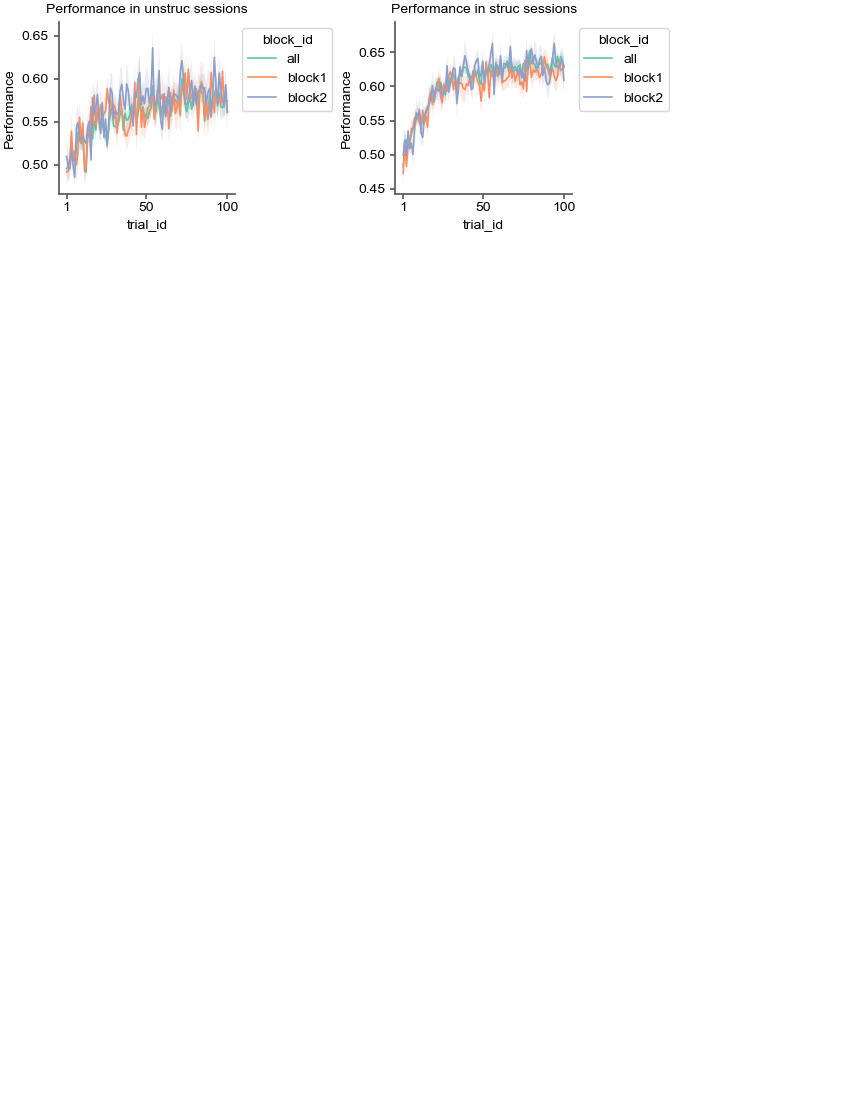

In [11]:
import seaborn as sns
import pandas as pd
from neuropy import plotting
import mab_subjects
import matplotlib.pyplot as plt

df = mab_subjects.GroupData().reward_prob.latest

fig = plotting.Fig(6, 3, num=1, fontsize=10)

for g, grp in enumerate(["unstruc", "struc"]):
    ax = fig.subplot(fig.gs[g])
    df_grp = df[df["grp"] == grp]

    sns.lineplot(
        data=df_grp,
        x="trial_id",
        y="rp",
        hue="block_id",
        palette="Set2",
        ax=ax,
        lw=1.2,
        err_kws=dict(edgecolor="none"),
        errorbar="se",
    )
    ax.set_title(f"Performance in {grp} sessions")
    ax.set_ylabel("Performance")
    ax.set_xticks([1, 50, 100])
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.show()